In [87]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,scale,StandardScaler,RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from tqdm.notebook import tqdm  # Import tqdm for progress bar
import seaborn as sns
from myMLlib import set_seed, load_data_list, rebalance_weight, plt_loss, plt_confusion, layer_activation


In [88]:
folderpath= ('/Users/stonyxiong/files/Research/dataset/New_bloodmeat16_right',
             '/Users/stonyxiong/files/Research/dataset/New_bloodmeat18_left',
             '/Users/stonyxiong/files/Research/dataset/New_bloodmeat26_left')

materials = ['blood','meat']
realmater = ["Silicone/Water","Silicone"]
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 14
})

In [89]:
data_list,labels = load_data_list(folderpath,materials,[3e3 , 3e3, 3e3])
time_vec = pd.read_csv(f'{folderpath[0]}/time_vector.csv', usecols=[1]).values

In [90]:
seed = 43
set_seed(seed)
snapshot = np.array(data_list[0]+data_list[1]).squeeze()[:,0:3000]
y = np.array(labels[0]+ labels[1]).reshape(-1,1)
snapshot_r = np.array(data_list[2]).squeeze()[:,0:3000]
y_r = np.array(labels[2]).reshape(-1,1)
print(snapshot.shape)
print(y.shape)
print(snapshot_r.shape)
print(y_r.shape)


(6000, 3000)
(6000, 1)
(3000, 3000)
(3000, 1)


In [91]:
snapshot_train, snapshot_test, y_train, y_test = train_test_split(snapshot, y, test_size=0.001, random_state=42)

In [92]:
Xp_train = snapshot_train
Xp_test = snapshot_test
Xp_r = snapshot_r

In [93]:
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if (hasattr(torch.backends, "mps") and torch.backends.mps.is_available()) 
    else "cpu"
)
print("Using device:", device)

Using device: mps


In [94]:
# Split data into train and test sets


X_train = scale(Xp_train,axis=1)
X_test = scale(Xp_test,axis=1)
X_r_test = scale(Xp_r,axis=1)
scaler = StandardScaler()
# scaler = RobustScaler(unit_variance=False)
# X_train = scaler.fit_transform(Xp_train)
# X_test = scaler.transform(Xp_test)
# X_r_test = scaler.transform(Xp_r)
siglenth = X_train.shape[1]
scaler = MinMaxScaler(feature_range=(0, len(materials)-1))
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_r_test = scaler.transform(y_r)

X_r_ver,X_r_te, y_r_ver, y_r_te = train_test_split(X_r_test, y_r_test, train_size = 0.3,random_state=42)

print(X_r_ver.shape)
print(X_r_te.shape)


(900, 3000)
(2100, 3000)


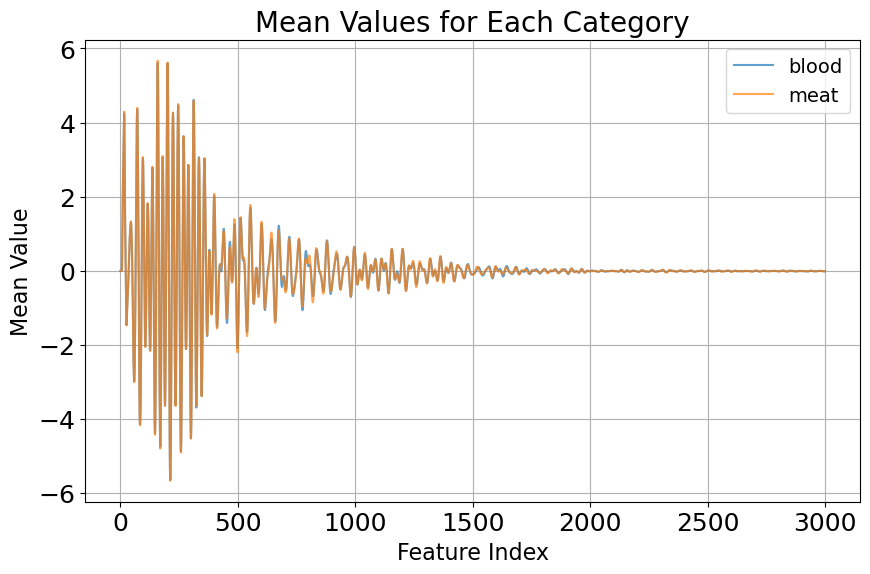

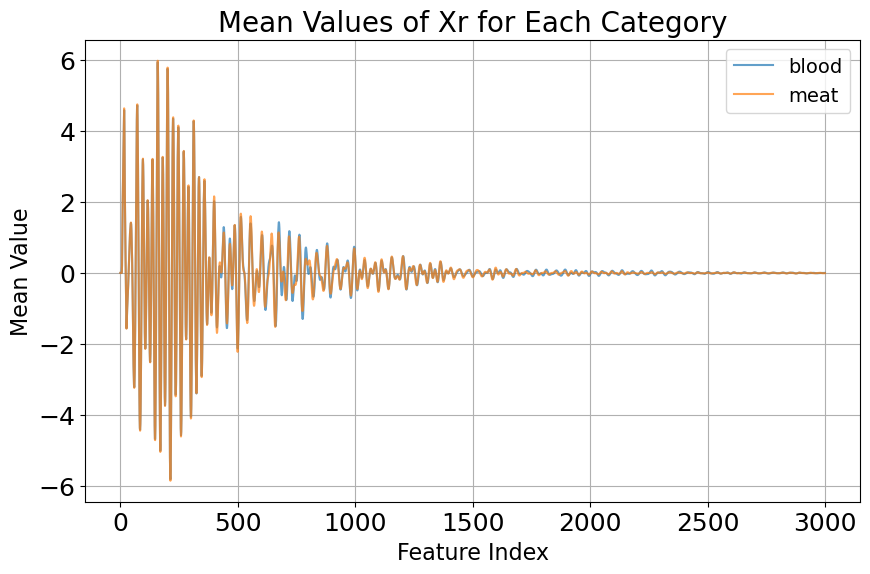

In [95]:
indices1 = {}
indices2 = {}
unique_labels = np.unique(y_train)
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(y_train.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_train[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[int(label)]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values for Each Category")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices2[materials[i]] = np.where(y_r_te.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_r_te[indices2[materials[i]]].mean(axis=0) # type: ignore
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[i]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values of Xr for Each Category")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# 2. 定义 1D-CNN 模型
class CNN1D(nn.Module):
    def __init__(self, input_length, num_classes):
        super(CNN1D, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(1, 2, kernel_size=2, padding=1), # index 0
            nn.BatchNorm1d(2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(4),   # L -> L/2

            nn.Conv1d(2, 16, kernel_size=3, padding=1), # index 4
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(4),   # L/2 -> L/4

            nn.Conv1d(16, 32, kernel_size=3, padding=1), # index 8
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(4)   # L -> L/2
        )

        pooled_length = input_length // (4*4*4)

        # 分类器部分
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * pooled_length, 64),  #64 × (L//8)
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


set_seed(seed)

In [127]:
model = CNN1D(input_length=siglenth, num_classes=len(materials)).to(device)

class_weights,_ = rebalance_weight(y_train)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
# 4. 将 numpy 数据转为 torch 张量并移动到 device

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).squeeze().to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).squeeze().to(device)
X_r_ver_tensor = torch.tensor(X_r_ver, dtype=torch.float32).unsqueeze(1).to(device)
y_r_ver_tensor = torch.tensor(y_r_ver, dtype=torch.long).squeeze().to(device)
X_r_te_tensor = torch.tensor(X_r_te, dtype=torch.float32).unsqueeze(1).to(device)
y_r_te_tensor = torch.tensor(y_r_te, dtype=torch.long).squeeze().to(device)

In [128]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu()
    return hook

# 给每个 Conv1d 注册 hook
for idx, layer in enumerate(model.feature_extractor):
    if isinstance(layer, nn.Conv1d):
        layer.register_forward_hook(get_activation(f"conv{idx}"))
conv1 = model.feature_extractor[0]

# with torch.no_grad():
#     # modify weights of the first Conv1d layer
#     kernels = [
#         [-1,  0,  1],
#         [-1,  1, -1],
#         [ 1, -1,  1],
#         [ 1,  0, -1]
#     ]
#     # for in_channels=1, weight.data[i, :, :] has shape (1, 3)
#     for i, k in enumerate(kernels):
#         t = torch.tensor(k, dtype=conv1.weight.dtype, device=conv1.weight.device)
#         conv1.weight.data[i, :, :] = t.unsqueeze(0)
# for param in conv1.parameters():
#     param.requires_grad = False

In [129]:
# 5. 训练模型
optimizer = optim.AdamW(model.parameters(), lr=5e-5,weight_decay=1e-4)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
verify_dataset = TensorDataset(X_r_ver_tensor, y_r_ver_tensor)

train_loader  = DataLoader(train_dataset, batch_size=3000, shuffle=True)
verify_loader = DataLoader(verify_dataset, batch_size=1000, shuffle=False)

num_epochs = 2000
train_losses = []
verify_losses = []

pbar = tqdm(range(int(num_epochs)), desc="Training", leave=True)
for epoch in pbar:
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    # —— 2. 验证 —— #
    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in verify_loader:
            verify_outputs = model(batch_X)
            verify_loss = criterion(verify_outputs, batch_y)
        verify_losses.append(verify_loss.item())
    # —— 3. 更新 tqdm 的显示 —— #
    pbar.set_postfix(train_loss=loss.item(), verify_loss=verify_loss.item())

Training:   0%|          | 0/2000 [00:00<?, ?it/s]

In [130]:
print(len(train_losses))
print(len(verify_losses))

2000
2000


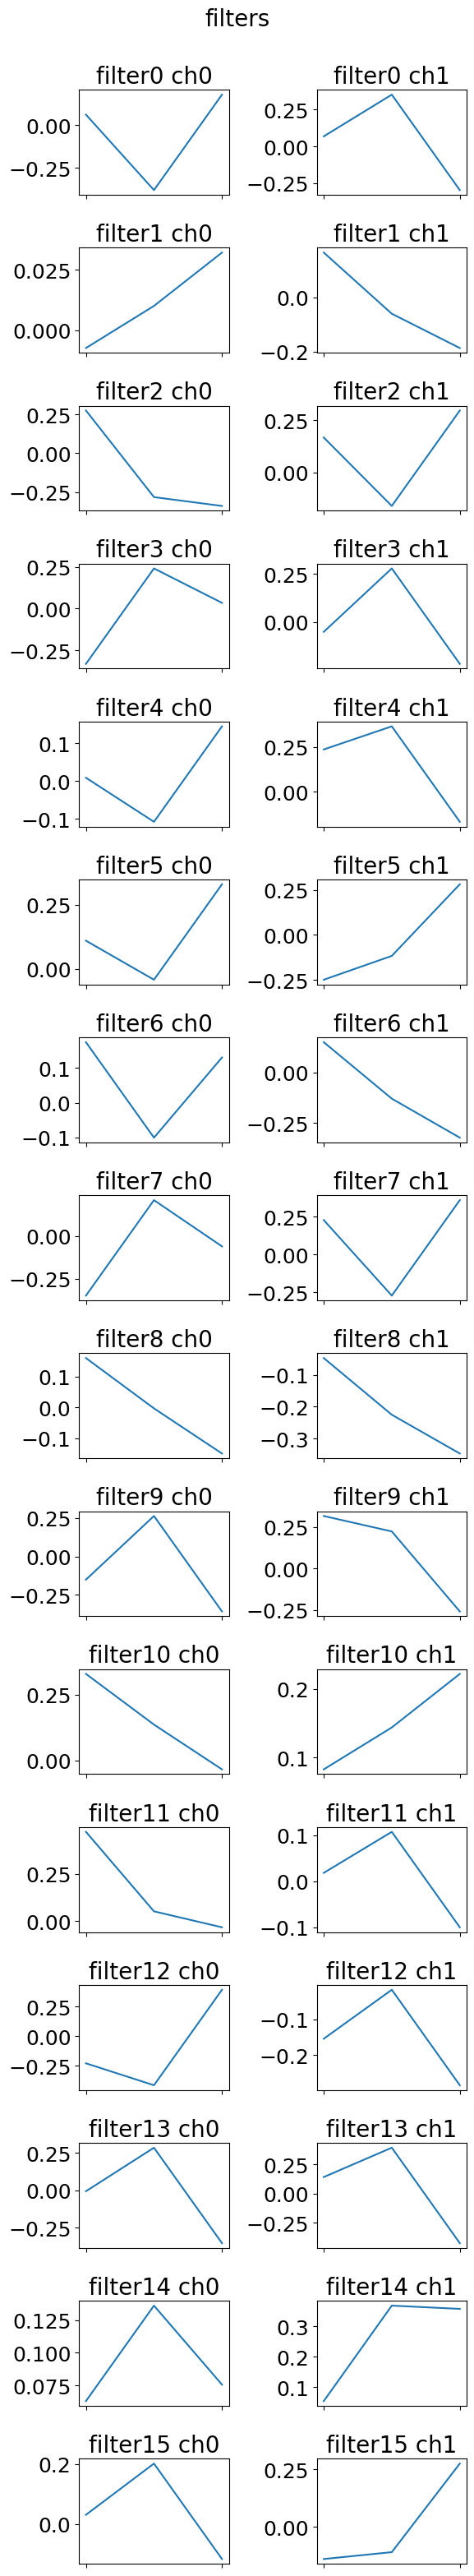

In [144]:
w = model.feature_extractor[4].weight.data.cpu().numpy()

# 如果想一次性看看所有 in→out 的小图，可以循环：
n_out, n_in, k = w.shape
fig, axes = plt.subplots(n_out, n_in, figsize=(n_in*3, n_out*2), squeeze=False)
# optional spacing between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_out):
    for j in range(n_in):
        axes[i, j].plot(w[i, j, :])
        axes[i, j].set_title(f'filter{i} ch{j}')
        axes[i, j].tick_params(left=True, labelleft=True,
                               bottom=True, labelbottom=False)

fig.suptitle("filters", fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

torch.Size([5994, 1, 3000])
conv0 输出 shape: torch.Size([1, 2, 3001])
conv4 输出 shape: torch.Size([1, 16, 750])
conv8 输出 shape: torch.Size([1, 32, 187])


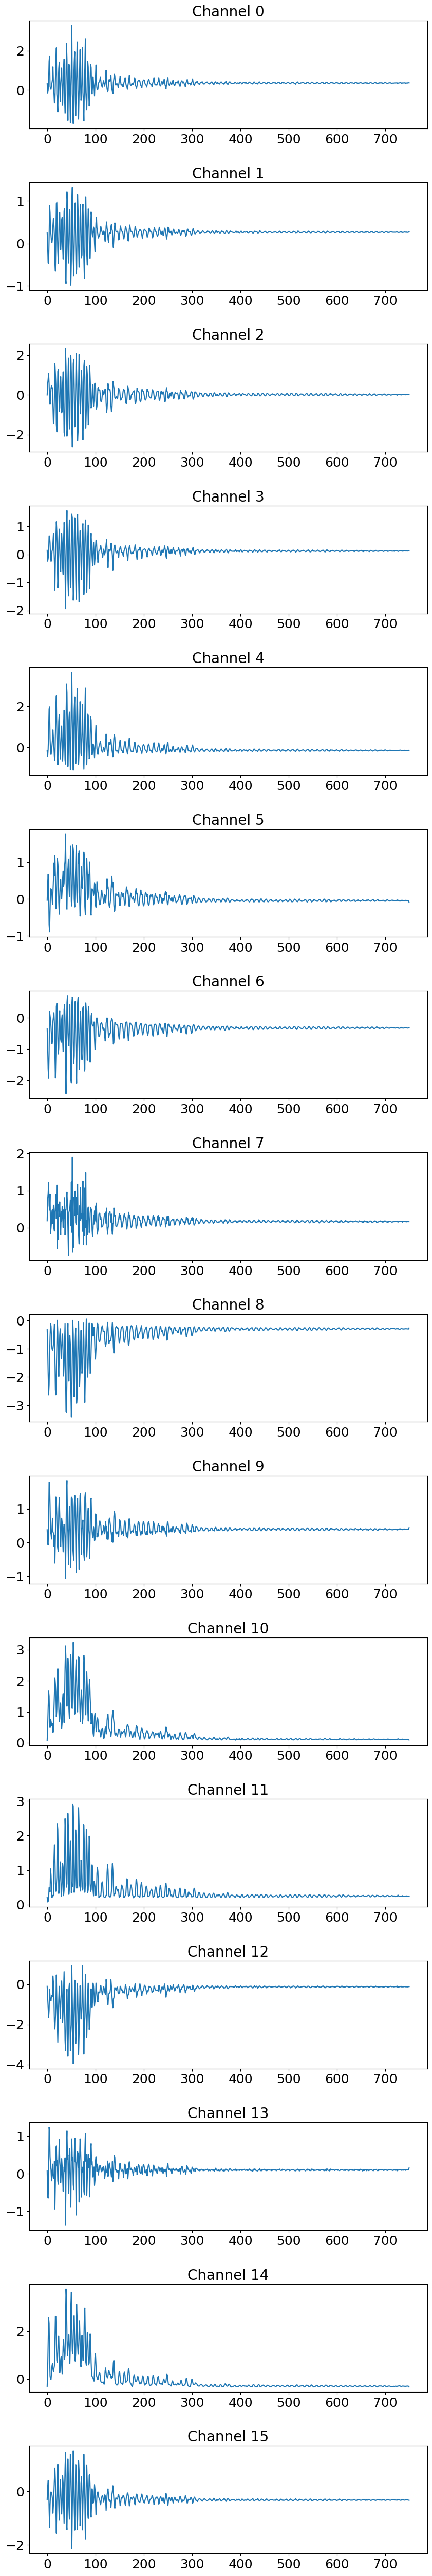

In [145]:
sample = X_train_tensor[100].unsqueeze(0).to(device)
_ = model(sample)
print(X_train_tensor.shape)
# 查看各层通道数
for name, feat in activations.items():
    print(f"{name} 输出 shape:", feat.shape)
    # feat.shape = (1, out_channels, L_out)
cnn_out = activations['conv4'].squeeze(0).numpy()
fig, axes = plt.subplots(cnn_out.shape[0], 1, figsize=[10, 4*cnn_out.shape[0]])
fig.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(cnn_out.shape[0]):
    axes[i].plot(cnn_out[i])
    axes[i].set_title(f"Channel {i}")
plt.show()


In [146]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    train_outputs = model(X_train_tensor)
    _, predicted = torch.max(test_outputs, 1)
    _, predicted_train = torch.max(train_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    predicted_np_train = predicted_train.cpu().numpy()
    accuracy_train = accuracy_score(y_train,predicted_np_train)
    accuracy = accuracy_score(y_test, predicted_np)
    cm = confusion_matrix(y_test, predicted_np)

Accuracy: 1.0
Accuracy_train: 1.0
Confusion Matrix:
[[3 0]
 [0 3]]


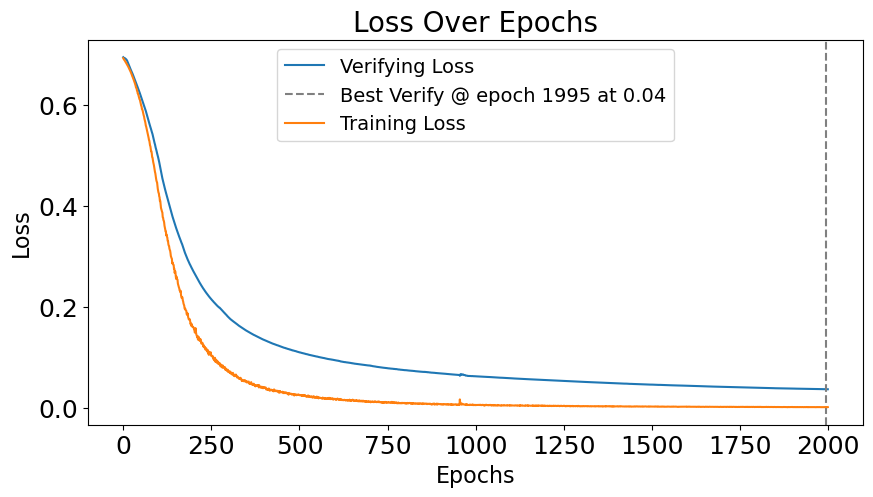

In [147]:
print(f'Accuracy: {accuracy}')
print(f'Accuracy_train: {accuracy_train}')
print(f'Confusion Matrix:\n{cm}')

plt_loss(train_losses=train_losses, verifying_losses =verify_losses)

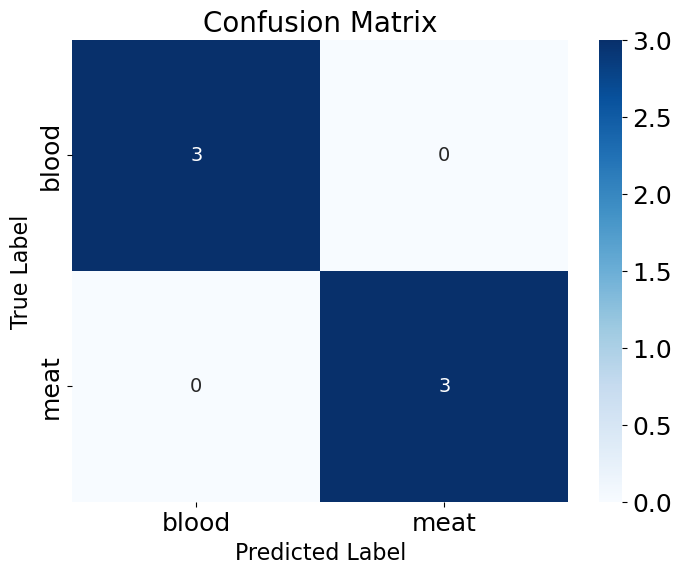

Accuracy: 1.0
              precision    recall  f1-score   support

       blood       1.00      1.00      1.00         3
        meat       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [148]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=materials,
            yticklabels=materials)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix")
plt.show()

# Convert y_test to integer labels
y_test_int = y_test.astype(int)

# Show classification reportaccuracy
report = classification_report(y_test_int, predicted_np,
                               target_names=materials, labels=range(len(materials)))
print("Accuracy:", accuracy)
print(report)

In [149]:
model.eval()
with torch.no_grad():
    r_ver_outputs = model(X_r_ver_tensor)
    _, predicted = torch.max(r_ver_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    ver_accuracy = accuracy_score(y_r_ver, predicted_np)
    ver_cm = confusion_matrix(y_r_ver, predicted_np)

Accuracy: 0.9933333333333333


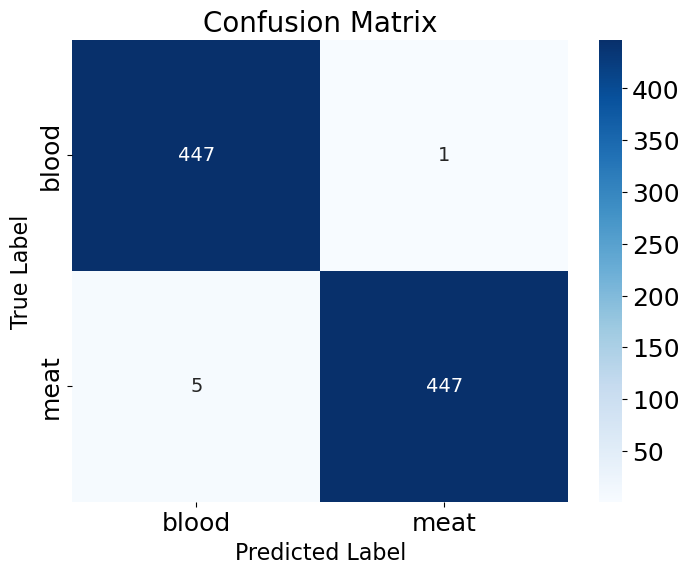

In [150]:
print(f'Accuracy: {ver_accuracy}')
plt_confusion(ver_cm,materials)

In [151]:
model.eval()
with torch.no_grad():
    r_te_outputs = model(X_r_te_tensor)
    _, predicted = torch.max(r_te_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    r_accuracy = accuracy_score(y_r_te, predicted_np)
    r_cm = confusion_matrix(y_r_te, predicted_np)

Accuracy: 0.9795238095238096


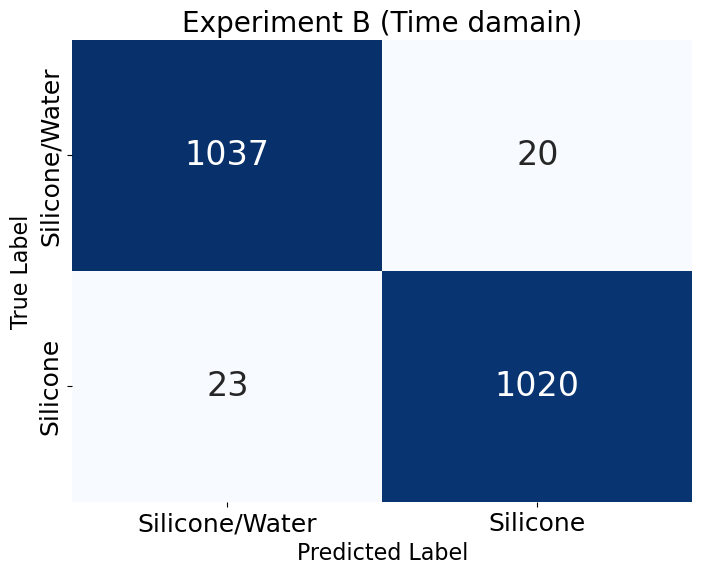

In [152]:
print(f'Accuracy: {r_accuracy}')
plt.figure(figsize=(8,6))
sns.heatmap(
    r_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=realmater,
    yticklabels=realmater,
    annot_kws={"size": 24}  # 设置数字字体大小
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Experiment B (Time damain)")
plt.xticks()
plt.yticks()
plt.show()


In [153]:
model.eval()
with torch.no_grad():
    logits = model(X_r_te_tensor.to(device))    # [N,2]
    # 方法 A：用 softmax 概率
    probs = torch.softmax(logits, dim=1)           # [N, 2]
    all_scores = probs[:, 1].cpu().numpy()         # 正类概率 ∈ [0,1]
    all_labels = y_r_te  # shape (N,)

In [154]:
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = roc_auc_score(all_labels, all_scores)

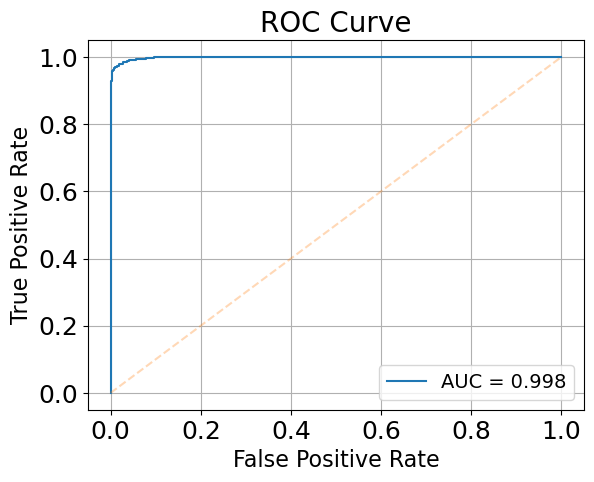

In [155]:
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--', alpha=0.3)   # 对角参考线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()